In [2]:
import numpy as np
import pandas as pd
import igraph as ig
import cairo
import math

from io import BytesIO
import IPython.display

In [3]:
df = pd.read_csv("data/test.csv")

# convert to strings
df = df.astype(str)
# replace nans with blank string
df = df.applymap(lambda s: "" if s == "nan" else s)
# remove newlines
df = df.applymap(lambda s: s.rstrip('\n'))

# display data
df

,Full Name,Nickname,Year Born,Father,Mother,Spouse,Children
0,Mother,Mom,1969,Maternal Grandfather,Maternal Grandmother,Father,"Me, Brother, Sister"
1,Father,Dad,1965,Paternal Grandfather,Paternal Grandmother,Mother,"Me, Brother, Sister"
2,Me,,1994,Father,Mother,,
3,Sister,Sis,1990,Father,Mother,,
4,Brother,Bro,1998,Father,Mother,,
5,Paternal Grandfather,PGP,1938,,,Paternal Grandmother,"Father, Ben"
6,Paternal Grandmother,PGM,1940,,,Paternal Grandfather,"Father, Ben"
7,Maternal Grandfather,MGP,1941,,,Maternal Grandmother,"Mother, Sue"
8,Maternal Grandmother,MGM,1946,,,Maternal Grandfather,"Mother, Sue"
9,Ben,,1960,Paternal Grandfather,Paternal Grandmother,,


In [4]:
# number of vertices
V = len(df)
# create index dictionary
di = dict()
for i in range(V):
    di[df["Full Name"][i]] = i
di[""] = -1

def getChildren(v):
    return list(map(lambda s: s.strip(), df.loc[v, "Children"].split(",")))

# create edges
E = [(source, di[dest]) for source in range(V) \
        for dest in list(map(lambda s: s.strip(), df.loc[source, "Children"].split(",")))]

# create graph
G = ig.Graph(directed = True)
G.add_vertices(V)
G.add_edges([e for e in E if e[1] != -1])

# visual styles
vs = {}
vs["vertex_label"] = [df.loc[v, "Nickname"] if df.loc[v, "Nickname"] != "" \
                        else df.loc[v, "Full Name"] for v in range(V)]
vs["layout"] = G.layout("rt")

In [5]:
children = G.degree(mode="out")
parents = G.degree(mode="in")
spouses = {v:int(di[df.loc[v, "Spouse"]]) for v in range(V)}

def height(node):
    if children[node] == 0:
        return -1
    else:
        return max(height(e[1]) for e in E if e[0] == node) + 1
    
def levelHelper(curr, node, level):
    if curr == -1:
        return 0
    
    if curr == node:
        return level
    
    downlevel = 0
    for i in getChildren(curr):
            child = di[i]
            downlevel = levelHelper(child, node, level+1)
            if downlevel != 0:
                return downlevel
    return downlevel
    
def level(node, ref):
    return levelHelper(ref, node, 1)

In [6]:
def topologicalSortUtil(v, visited, stack):
    if v == -1:
        return
    
    # mark node v as visited
    visited[v] = True
    
    # recurse for adjacent nodes
    for name in getChildren(v):
        child = di[name]
        if not visited[child]:
            topologicalSortUtil(child, visited, stack)
    
    # push vertex to stack to store result
    stack.append(v)
    
def topologicalSort():
    visited = [False]*V
    stack = []
    
    for i in range(V):
        if not visited[i]:
            topologicalSortUtil(i, visited, stack)
            
    return stack

In [7]:
def longestPath(v):
    topsort = topologicalSort()
    dist = [-1]*V
    dist[v] = 0
    
    while(len(topsort) != 0):
        u = topsort.pop()
        if dist[u] != -1:
            for name in getChildren(u):
                child = di[name]
                if dist[child] < dist[u] + 1:
                    dist[child] = dist[u] + 1
    return dist

In [8]:
lengths = [max(longestPath(i)) for i in range(V)]
maxlen = max(lengths)

In [9]:
# Returns greatest ancestors along paternal/maternal lines along with distance
def getGreatestAncestors(v):
    paternal = maternal = 0
    p = m = v
    while di[df.loc[p, "Father"]] != -1:
        paternal += 1
        p = di[df.loc[p, "Father"]]
    while di[df.loc[m, "Mother"]] != -1:
        maternal += 1
        m = di[df.loc[m, "Mother"]]
    return {"Paternal": (p, paternal), "Maternal": (m, maternal)}

# Returns furthest ancestor along paternal/maternal lines
def getGreatestAncestor(v):
    ga = getGreatestAncestors(v)
    maxline = max(ga, key=lambda k: ga[k][1])
    return ga[maxline][0]

In [10]:
[getGreatestAncestor(v) for v in range(V)]

[7, 5, 5, 5, 5, 5, 6, 7, 8, 5, 7, 11, 8]

In [11]:
levels = [level(v, getGreatestAncestor(v)) for v in range(V)]
print(levels)

[2, 2, 3, 3, 3, 1, 1, 1, 1, 2, 2, 1, 3]


In [12]:
lengths

[2, 2, 1, 1, 1, 3, 3, 3, 3, 1, 2, 2, 1]

In [13]:
df.loc[:, "Full Name"]

0                   Mother
1                   Father
2                       Me
3                   Sister
4                  Brother
5     Paternal Grandfather
6     Paternal Grandmother
7     Maternal Grandfather
8     Maternal Grandmother
9                      Ben
10                     Sue
11                   Peter
12                  Cousin
Name: Full Name, dtype: object

In [14]:
parents

[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2]

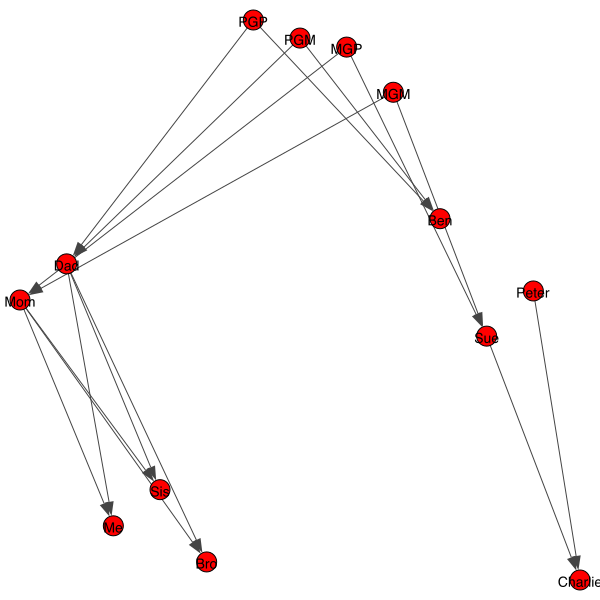

In [15]:
layout = vs["layout"]
vs["layout"] = [[layout[k][0], int(df.loc[k, "Year Born"])] for k in range(V)]
ig.plot(G, **vs)

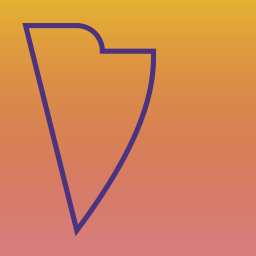

In [16]:
WIDTH, HEIGHT = 256, 256

svgio = BytesIO()
with cairo.SVGSurface(svgio, WIDTH, HEIGHT) as surface:
    ctx = cairo.Context(surface)

    ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

    pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
    pat.add_color_stop_rgba(1, 0.7, 0, 0, 0.5)  # First stop, 50% opacity
    pat.add_color_stop_rgba(0, 0.9, 0.7, 0.2, 1)  # Last stop, 100% opacity

    ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1)
    ctx.set_source(pat)
    ctx.fill()

    ctx.translate(0.1, 0.1)  # Changing the current transformation matrix

    ctx.move_to(0, 0)
    # Arc(cx, cy, radius, start_angle, stop_angle)
    ctx.arc(0.2, 0.1, 0.1, -math.pi / 2, 0)
    ctx.line_to(0.5, 0.1)  # Line to (x,y)
    # Curve(x1, y1, x2, y2, x3, y3)
    ctx.curve_to(0.5, 0.2, 0.5, 0.4, 0.2, 0.8)
    ctx.close_path()

    ctx.set_source_rgb(0.3, 0.2, 0.5)  # Solid color
    ctx.set_line_width(0.02)
    ctx.stroke()
    

IPython.display.SVG(data=svgio.getvalue())

In [17]:
# get an array of vertices in topview or bottomview of tree
def toporder(v, down=True):
    if v == -1:
        return
    
    # map of dist to levels and nodes
    m = {}
    q = []
    
    # add root to queue
    q.append((0, 0, v))
    
    while(len(q) > 0):
        dist, lvl, node = q.pop(0)
        
        if(dist not in m):
            m[dist] = (lvl, node)
            
        if(down):
            children = getChildren(node)
            # number of children
            nc = len(children)
            # mid index
            mid = (nc+1)/2
            
            for i, c in enumerate(children):
                
                # if child has no children
                if len(c) == 0:
                    continue
                
                q.append((dist+(mid-(i+1)), lvl+1, di[c]))
                
        else:
            pa = di[df.loc[node, "Father"]]
            ma = di[df.loc[node, "Mother"]]
            
            if pa != -1:
                q.append((dist-1, lvl+1, pa))
            if ma != -1:
                q.append((dist+1, lvl+1, ma))
                
    # list of the nodes in top view order
    ans = [m[k][1] for k in sorted(m)]
    
    return ans

In [18]:
toporder(di['Paternal Grandfather'])

[9, 5, 1, 2]

In [19]:
toporder(di["Me"], down=False)

[5, 1, 2, 0, 8]

In [20]:
def getWidth(v, down=True):
    if v == -1:
        return
    
    q = []
    
    # level of root
    lvl = 0
    # width variable
    w = 0
    # max width of tree
    mw = 0
    
    # add root to queue
    q.append((v, lvl))
    
    while(len(q) > 0):
        node, newlvl = q.pop(0)
        
        if newlvl != lvl:
            lvl = newlvl
            w = 0
            
        w += 1
        if(w > mw):
            mw = w
        
        if down:
            for c in getChildren(node):
                if(len(c) > 0):
                    q.append((di[c], lvl+1))
        else:
            pa = di[df.loc[node, "Father"]]
            ma = di[df.loc[node, "Mother"]]
            
            if pa != -1:
                q.append((pa, lvl+1))
            if ma != -1:
                q.append((ma, lvl+1))
    
    return mw

In [21]:
def getLeaves(v, down=True):
    if v == -1:
        return
    
    ans = []
    
    if down:
        for c in getChildren(v):
            # if child is leaf, add v to answer
            if di[c] == -1:
                ans += [v]
            else:
                # check leaves of children and add them
                ans += getLeaves(di[c])
    else:
        pa = di[df.loc[v, "Father"]]
        ma = di[df.loc[v, "Mother"]]
        
        # if no parents, add v to answer
        if pa == -1 and ma == -1:
            ans += [v]
        else: # check leaves of parents and add them
            if pa != -1:
                ans += getLeaves(pa, False)
            if ma != -1:
                ans += getLeaves(ma, False)
    
    return ans

In [22]:
# Get bottom leaves
leaves = set()
for v in range(V):
    leaves = leaves | set(getLeaves(v))
print("Leaves:", leaves)

# Get top roots
roots = set()
for v in range(V):
    roots = roots | set(getLeaves(v, down=False))
print("Roots:", roots)

# Find max width of tree
tree_width = 0

for v in leaves:
    w = getWidth(v, down=False)
    if w > tree_width:
        tree_width = w
        
for v in roots:
    w = getWidth(v)
    if w > tree_width:
        tree_width = w
        
print("Tree Width:", tree_width)

Leaves: {2, 3, 4, 9, 12}
Roots: {5, 6, 7, 8, 11}
Tree Width: 4


In [280]:
AGE_GAP = 10

# sort birth years
years = np.array([int(df.loc[v, "Year Born"]) for v in range(V)])
i = np.argsort(years)

# max tree width
tw = 0

# width at the given vertex's age group
W = np.ones(V, int)

# age group
k = 0
K = np.zeros(V, int) # age group array

# find age group and neighbors for each vertex
v = 0
while v < V-1:
#     print(years[i][v])
    
    vstart = v
    
    while(v+1 < V):
#         print(W[i])
        k = vstart
        # check if next birth is within age gap, add to width if it is
        if years[i][v+1] - years[i][v] < AGE_GAP:
            W[i[vstart:v+2]] = W[i[vstart]]
            K[i[vstart:v+2]] = k
            W[i[vstart:v+2]] += 1
            if W[i[vstart]] > tw:
                tw = W[i[vstart]]
            v += 1
        else:
            v += 1
            break

print("Neighbors:", W[i])
print("Age Groups:", K[i])

print("Tree Width:", tw)

Neighbors: [4 4 4 4 5 5 5 5 5 4 4 4 4]
Age Groups: [0 0 0 0 4 4 4 4 4 9 9 9 9]
Tree Width: 5


In [257]:
W

array([5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4])

In [281]:
# Get x position based on relative width compared to neighbors
X = np.arange(V)
for v in range(V):
    i = (K == K[v])
    if v > np.min(X[i]):
        continue
    else:
        for n in range(W[v]):
            vx[X[i][n]] = TREE_WIDTH/2 - NEIGHBOR_SPACING*W[v]/2 + n*NEIGHBOR_SPACING

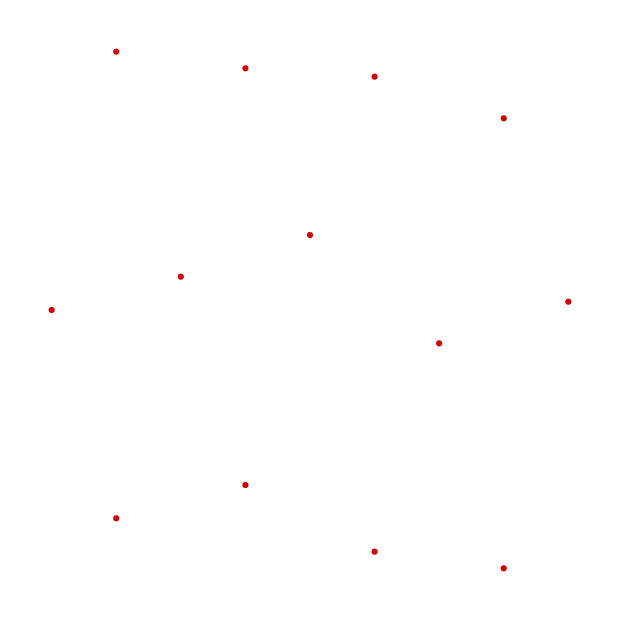

In [282]:
TREE_WIDTH = max(tw*100, (np.max(years) - np.min(years))*10)
TREE_HEIGHT = TREE_WIDTH
WIDTH, HEIGHT = TREE_WIDTH, TREE_HEIGHT
NEIGHBOR_SPACING = TREE_WIDTH/tw
BORDER_SCALE = 0.1

# Vertex positions
vx = np.zeros(V)
vy = np.array([years[v] for v in range(V)])

# Get x position based on relative width compared to neighbors
X = np.arange(V)
for v in range(V):
    i = (K == K[v])
    if v > np.min(X[i]):
        continue
    else:
        for n in range(W[v]):
            vx[X[i][n]] = TREE_WIDTH/2 - NEIGHBOR_SPACING*W[v]/2 + n*NEIGHBOR_SPACING
            
# Normalize positions
mx, Mx = np.min(vx), np.max(vx)
my, My = np.min(vy), np.max(vy)
vx = (BORDER_SCALE*WIDTH + (vx - mx)/(Mx - mx)*WIDTH)/((1+2*BORDER_SCALE)*WIDTH)
vy = (BORDER_SCALE*HEIGHT + (vy - my)/(My - my)*HEIGHT)/((1+2*BORDER_SCALE)*HEIGHT)

# Vertex size
vr = 0.005

svgio = BytesIO()
with cairo.SVGSurface(svgio, WIDTH, HEIGHT) as surface:
    cr = cairo.Context(surface)

    cr.scale(WIDTH, HEIGHT)  # Normalizing the canvas
    
    # Draw vertices
    for v in range(V):
        cr.arc(vx[v], vy[v], vr, 0, 2*math.pi)
        cr.set_source_rgb(0.8, 0, 0)
        cr.fill()

    
IPython.display.SVG(data=svgio.getvalue())

In [82]:

vx = np.array([v for v in range(V)])
vy = np.array([int(df.loc[v, "Year Born"]) for v in range(V)])
mx, Mx = np.min(vx), np.max(vx)
my, My = np.min(vy), np.max(vy)

In [173]:
W[i[0:2]] = 2
W[i]

array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])